Figure 2  

Flash and beep responses across conditions and stimuli locations

In [52]:
# Imports
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# data handling
import pandas as pd
import numpy as np

# data analysis
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [53]:
# plot types: violin, strip, boxen, swarm

plot_type = 'boxen'

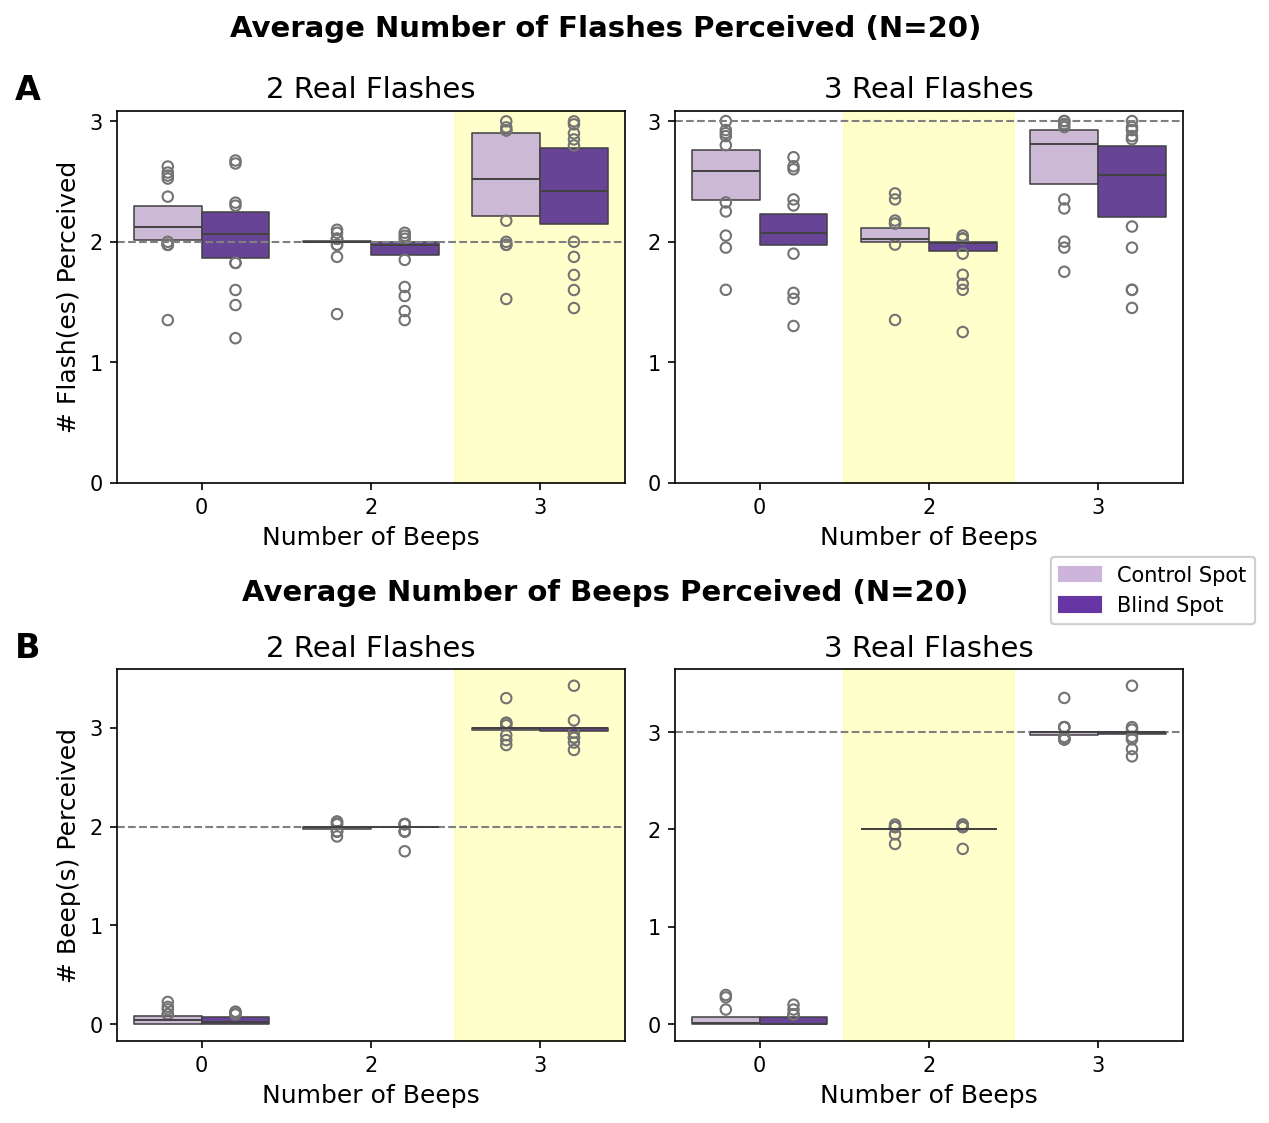

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                 9600
Model:                            GLM   Df Residuals:                     9596
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13594.
Date:                Tue, 01 Jul 2025   Deviance:                       1576.8
Time:                        14:47:37   Pearson chi2:                 1.46e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.008319
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6578      0.037     17.765      0.0

In [ ]:
# 2 x 2
# Panel A: 2 Real Flashes, 3 Real Flashes (Flash response)
# Panel B: 2 Real Flashes, 3 Real Flashes (Beep response)
# Hue: by location (blindspot 0/1)


# Load all CSV files
csv_files = [f for f in os.listdir('csv') if f.endswith('.csv')]
dfs = [pd.read_csv(os.path.join('csv', f)) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Create Flash and Beep DFs
flash_df = df[df['response_type'] == 1].copy()
beep_df = df[df['response_type'] == 2].copy()

# Create data for plotting
# A (left): 2 Real Flashes (Flash response)
a_two = flash_df[flash_df['n_flash'] == 2].groupby(
    ['subj_id', 'n_beep', 'blindspot'], as_index=False).agg({'response': 'mean'})
# print(a_two.head())

# A (right): 3 Real Flashes (Flash response)
a_three = flash_df[flash_df['n_flash'] == 3].groupby(
    ['subj_id', 'n_beep', 'blindspot'], as_index=False).agg({'response': 'mean'})

# B (left): 2 Real Flashes (Beep response)
b_two = beep_df[beep_df['n_flash'] == 2].groupby(
    ['subj_id', 'n_beep', 'blindspot'], as_index=False).agg({'response': 'mean'})
# print(b_two.head())

# B (right): 3 Real Flashes (Beep response)
b_three = beep_df[beep_df['n_flash'] == 3].groupby(
    ['subj_id', 'n_beep', 'blindspot'], as_index=False).agg({'response': 'mean'})

fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=150)

data_to_plot = [
    (a_two, '2 Real Flashes', axs[0, 0], '# Flash(es) Perceived'),
    (a_three, '3 Real Flashes', axs[0, 1], ''),
    (b_two, '2 Real Flashes', axs[1, 0], '# Beep(s) Perceived'),
    (b_three, '3 Real Flashes', axs[1, 1], '')
]

custom_palette = {0: '#cdb4db', 1: '#6636a5'}

for data, title, ax, ylabel in data_to_plot:
    
    if title == '2 Real Flashes':
        # add a dashed line at y=2
        ax.axhline(y=2, color='grey', linestyle='--', linewidth=1, label='_nolegend_')
        ax.axvspan(1.5, 2.5, color='yellow', edgecolor=None, alpha=0.2, label='_nolegend_')
    else:
        ax.axhline(y=3, color='grey', linestyle='--', linewidth=1, label='_nolegend_')
        ax.axvspan(0.5, 1.5, color='yellow', edgecolor=None, alpha=0.2, label='_nolegend_')

    if plot_type == 'violin':
        sns.violinplot(
            data=data, x='n_beep', y='response', hue='blindspot',
            split=True, inner='quart', palette=custom_palette, ax=ax,
            legend=False
            )
    elif plot_type == 'strip':
        sns.stripplot(
            data=data, x='n_beep', y='response', hue='blindspot',
            dodge=True, palette=custom_palette, size=5, jitter=0.1, 
            ax=ax, legend=False,
            alpha=0.7, edgecolor='gray'
            )
    elif plot_type == 'boxen':
        sns.boxenplot(
            data=data, x='n_beep', y='response', hue='blindspot',
            palette=custom_palette, ax=ax, legend=False
            )
    elif plot_type == 'swarm':
        sns.swarmplot(
            data=data, x='n_beep', y='response', hue='blindspot',
            palette=custom_palette, ax=ax, legend=False, dodge=True, size=3
            )

    ax.set_yticks([0,1,2,3])
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Number of Beeps', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    handles = [
        plt.Rectangle((0,0), 1, 1, color=custom_palette[0], label='Control Spot'),
        plt.Rectangle((0,0), 1, 1, color=custom_palette[1], label='Blind Spot')
    ]
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.05, 0.45), ncol=1, fontsize=10)



# Add row labels
for row, label, title, yloc in zip([0, 1], ['A', 'B'], ['Average Number of Flashes Perceived (N=20)', 'Average Number of Beeps Perceived (N=20)'], [0.93, 0.46]):
    axs[row, 0].text(-0.15, 1.1, label, transform=axs[row, 0].transAxes,
                    fontsize=16, fontweight='bold', va='top', ha='right')
    fig.text(0.5, yloc, title, 
            ha='center', va='top', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(
    hspace=0.5, 
    top=0.85, 
    # right=0.95,
    )
plt.show()

# Prepare the dataframe
analysis_df = flash_df.copy()

# For count models, we need integer responses - ensure your response variable is integer
analysis_df['response'] = analysis_df['response'].round().astype(int)

# Basic Poisson model
poisson_model = smf.glm(
    formula='response ~ n_flash + n_beep + blindspot',
    data=analysis_df,
    family=sm.families.Poisson()
).fit()

print(poisson_model.summary())

# More complex model with interaction terms
poisson_model_int = smf.glm(
    '''response ~ n_flash*n_beep + n_flash:blindspot + n_beep:blindspot''',
    data=analysis_df,
    family=sm.families.Poisson()
).fit().summary()
print(poisson_model_int)